# Data Collection and Cleaning

In [25]:
!pip install sodapy

In [26]:
import pandas as pd
import numpy as np
import holidays
import datetime
import requests
from sodapy import Socrata
import matplotlib.pyplot as plt

In [27]:
# date_extract_dow() - 0 = Sunday, 6 = Saturday
client = Socrata("data.iowa.gov", None)
results = client.get("m3tr-qhgy",
                     query="""select Date, date_extract_m(Date) as Month, date_extract_dow(Date) as DayOfWeek,
                     name as StoreName, Zipcode, City, County, im_desc, category_name, sale_liters, sale_dollars
                     LIMIT 10000""")
df_liquor = pd.DataFrame.from_records(results)

In [28]:
df_liquor.head()

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,im_desc,category_name,sale_liters,sale_dollars
0,2020-11-06T00:00:00.000,11,5,FAREWAY STORES #827 / CENTERVILLE,52544,CENTERVILLE,APPANOOSE,KAHLUA COFFEE,COFFEE LIQUEURS,12.00,272.76
1,2020-07-31T00:00:00.000,7,5,HOMETOWN MARKET / CENTRAL CITY,52214,CENTRAL CITY,LINN,JOSE CUERVO AUTHENTIC STRAWBERRY MARGARITA,COCKTAILS/RTD,10.50,78.66
2,2020-11-06T00:00:00.000,11,5,INDY 66 #928 / INDIANOLA,50125,INDIANOLA,WARREN,OLE SMOKY SALTY CARAMEL WHISKEY,NEUTRAL GRAIN SPIRITS FLAVORED,4.50,90.00
3,2020-11-04T00:00:00.000,11,3,GRAETTINGER MARKET,51342,GRAETTINGER,PALO ALTO,FIVE STAR,BLENDED WHISKIES,2.00,13.20
4,2020-11-06T00:00:00.000,11,5,SMOKIN' JOE'S #10 TOBACCO AND LIQUOR OUTLET,52302,MARION,LINN,FIREBALL CINNAMON WHISKEY,WHISKEY LIQUEUR,2.00,34.02


In [29]:
def alc_type_cat(alc):
    alc_categories = {
        "VODKA": ["VODKA"],
        "WHISKY": ["WHISKY", "WHISKIES"],
        "RUM": ["RUM"],
        "GIN": ["GIN"],
        "TEQUILA": ["TEQUILA"],
        "BRANDY": ["BRANDIES", "BRANY"],
        "SCHNAPPS": ["SCHNAPPS"],
        "SPIRITS": ["SPIRITS"],
    }

    for category, keywords in alc_categories.items():
        for keyword in keywords:
          try:
            if keyword in alc:
                return category
          except:
            return "OTHER"
    return "OTHER"

In [30]:
def alc_type_num(alc):
    alc_categories = {
        "VODKA": 1,
        "WHISKY": 2,
        "RUM": 3,
        "GIN": 4,
        "TEQUILA": 5,
        "BRANDY": 6,
        "SCHNAPPS": 7,
        "SPIRITS": 8,
    }

    for category, number in alc_categories.items():
        if any(keyword in alc for keyword in category.split()):
            return number

    return 9

## Data Sets to merge with df_liquor

In [31]:
url = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_Iowa"
df_colleges = pd.read_html(url)[0]

In [32]:
us_holidays = holidays.country_holidays('US', years=range(2012, 2024))
def near_holi(date):
  return int(bool(us_holidays[date - datetime.timedelta(weeks=2):date]))

In [33]:
df_colleges.head()

,Institution,Location(s)[note 2],Control[note 3],Type[note 4],Enrollment[7] (spring 2012),Founded,Accreditation[7]
0,University of Iowa,Iowa City,Public,Research university,"31,498[8]",1847[9],"HLC, ACPE, ABA, ADA, APTA, APA, ASHA, CPE, CAH..."
1,Iowa State University,Ames,Public,Research university,34732,1858[10],"HLC, AAMFT, ADA, APA, AVMA, NASM"
2,University of Northern Iowa,Cedar Falls,Public,Master's university,13168,1876[11],"HLC, ASHA, NASM"
3,Clinton Community College,Clinton,Public,Associate's college,1700,1946[12],HLC
4,Des Moines Area Community College,Ankeny,Public,Associate's college,25425,1966[13],"HLC, ABFSE, ADA, NLNAC"


In [34]:
df_colleges.rename(columns={"Location(s)[note 2]": "City"}, inplace=True)
df_colleges.rename(columns={"Enrollment[7] (spring 2012)": "Enrollment"}, inplace=True)
df_colleges = df_colleges[["Institution", "City", "Enrollment"]]
df_colleges["City"] = df_colleges["City"].str.upper()
df_colleges.head()

<ipython-input-34-7801ff43b533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["City"] = df_colleges["City"].str.upper()


,Institution,City,Enrollment
0,University of Iowa,IOWA CITY,"31,498[8]"
1,Iowa State University,AMES,34732
2,University of Northern Iowa,CEDAR FALLS,13168
3,Clinton Community College,CLINTON,1700
4,Des Moines Area Community College,ANKENY,25425


In [35]:
# Remove content in brackets from the Enrollment column and convert it to integers
df_colleges["Enrollment"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
df_colleges["Enrollment"] = df_colleges["Enrollment"].str.replace(",", "").astype(int)

# Define the classification criteria for college size
def classify_college_size(enrollment):
    if enrollment > 20000:
        return "Large"
    elif enrollment > 5000:
        return "Midsize"
    else:
        return "Small"

# Create a new column for college size classification
df_colleges["Size"] = df_colleges["Enrollment"].apply(classify_college_size)
df_colleges.head()

<ipython-input-35-21062b1f8b25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["Enrollment"] = df_colleges["Enrollment"].str.replace(r"\[.*\]", "", regex=True)
<ipython-input-35-21062b1f8b25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_colleges["Enrollment"] = df_colleges["Enrollment"].str.replace(",", "").astype(int)
<ipython-input-35-21062b1f8b25>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

,Institution,City,Enrollment,Size
0,University of Iowa,IOWA CITY,31498,Large
1,Iowa State University,AMES,34732,Large
2,University of Northern Iowa,CEDAR FALLS,13168,Midsize
3,Clinton Community College,CLINTON,1700,Small
4,Des Moines Area Community College,ANKENY,25425,Large


In [36]:
df_liquor["sale_liters"] =df_liquor["sale_liters"].astype(float)
df_liquor["sale_dollars"] = df_liquor["sale_dollars"].astype(float)

In [37]:
df_liquor["Date"] = df_liquor["Date"].map(lambda date: datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.%f"))
df_liquor["NearHoliday"] = df_liquor["Date"].map(near_holi)
df_liquor["NearCollege"] = df_liquor["City"].map(lambda city: 1 if city in df_colleges["City"].values else 0)

# Create a dictionary to map college cities to their sizes
college_size_mapping = df_colleges.set_index("City")["Size"].to_dict()

df_liquor["College_Size"] = df_liquor["City"].map(
    lambda city: college_size_mapping.get(city) if city in college_size_mapping and df_liquor.at[df_liquor[df_liquor["City"] == city].index[0], "NearCollege"] == 1 else None
)

df_liquor["CostPerLiter"] = df_liquor["sale_dollars"] / df_liquor["sale_liters"]
df_liquor["Category"] = df_liquor["category_name"].map(alc_type_cat)
df_liquor["CategoryNum"] = df_liquor["category_name"].map(alc_type_num)

In [38]:
df_liquor.head()

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,im_desc,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,College_Size,CostPerLiter,Category,CategoryNum
0,2020-11-06,11,5,FAREWAY STORES #827 / CENTERVILLE,52544,CENTERVILLE,APPANOOSE,KAHLUA COFFEE,COFFEE LIQUEURS,12.0,272.76,0,0,None,22.730000,OTHER,9
1,2020-07-31,7,5,HOMETOWN MARKET / CENTRAL CITY,52214,CENTRAL CITY,LINN,JOSE CUERVO AUTHENTIC STRAWBERRY MARGARITA,COCKTAILS/RTD,10.5,78.66,0,0,None,7.491429,OTHER,9
2,2020-11-06,11,5,INDY 66 #928 / INDIANOLA,50125,INDIANOLA,WARREN,OLE SMOKY SALTY CARAMEL WHISKEY,NEUTRAL GRAIN SPIRITS FLAVORED,4.5,90.00,0,1,Small,20.000000,SPIRITS,8
3,2020-11-04,11,3,GRAETTINGER MARKET,51342,GRAETTINGER,PALO ALTO,FIVE STAR,BLENDED WHISKIES,2.0,13.20,0,0,None,6.600000,WHISKY,9
4,2020-11-06,11,5,SMOKIN' JOE'S #10 TOBACCO AND LIQUOR OUTLET,52302,MARION,LINN,FIREBALL CINNAMON WHISKEY,WHISKEY LIQUEUR,2.0,34.02,0,0,None,17.010000,OTHER,9


In [39]:
df_liquor["Category"].value_counts()

WHISKY      2668
VODKA       2432
OTHER       2023
RUM          987
SCHNAPPS     517
BRANDY       506
TEQUILA      485
GIN          280
SPIRITS      102
Name: Category, dtype: int64

In [40]:
df_liquor["College_Size"].value_counts()

Small      3997
Midsize     916
Large       784
Name: College_Size, dtype: int64

<Axes: >

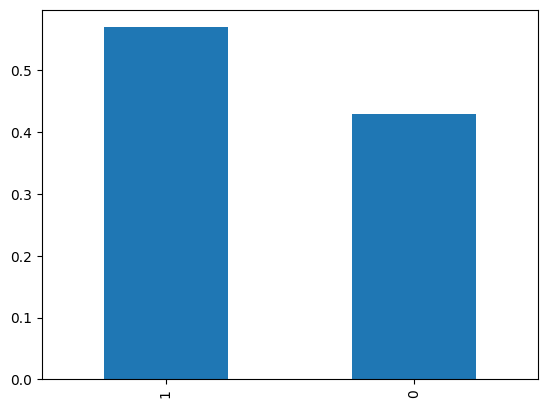

In [49]:
df_liquor["NearCollege"].value_counts(normalize=True).plot.bar()

In [42]:
df_liquor["sale_dollars"].describe()

count    10000.000000
mean       155.022379
std        355.560323
min          1.700000
25%         40.770000
50%         88.675000
75%        163.080000
max      12546.600000
Name: sale_dollars, dtype: float64

In [43]:
df_liquor[df_liquor["sale_dollars"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,im_desc,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,College_Size,CostPerLiter,Category,CategoryNum


In [44]:
df_liquor["sale_liters"].describe()

count    10000.000000
mean         9.149004
std         29.371873
min          0.050000
25%          1.500000
50%          4.800000
75%         10.500000
max       1320.000000
Name: sale_liters, dtype: float64

In [45]:
df_liquor[df_liquor["sale_liters"] <= 0]

,Date,Month,DayOfWeek,StoreName,Zipcode,City,County,im_desc,category_name,sale_liters,sale_dollars,NearHoliday,NearCollege,College_Size,CostPerLiter,Category,CategoryNum


<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

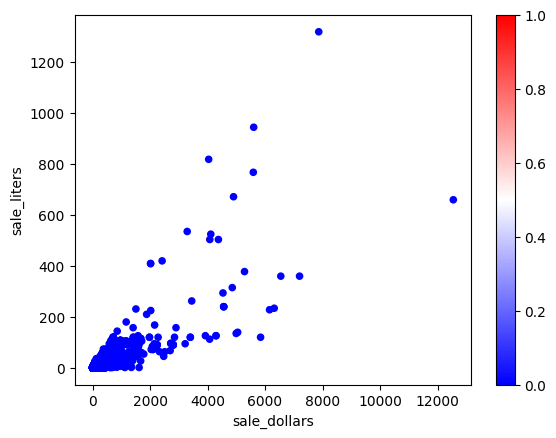

In [46]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["NearHoliday"], colormap="bwr")

<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

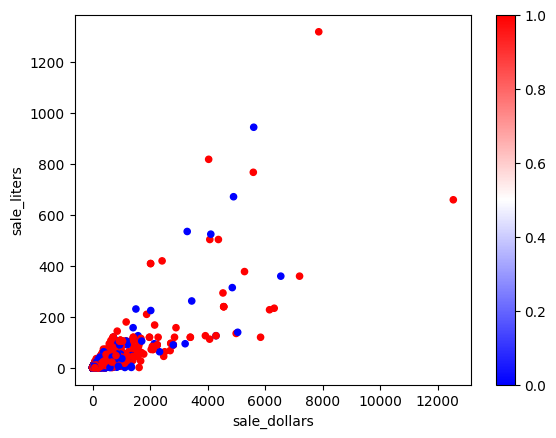

In [47]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["NearCollege"], colormap="bwr")

<Axes: xlabel='sale_dollars', ylabel='sale_liters'>

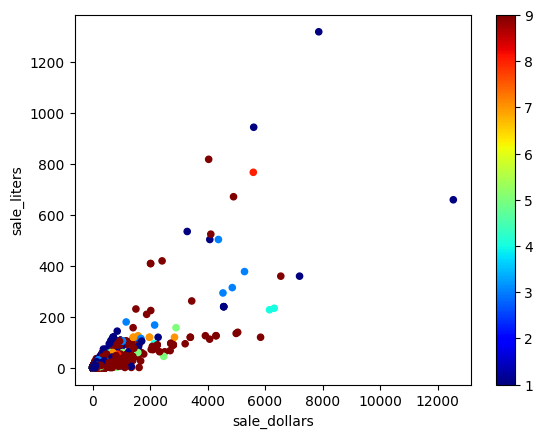

In [48]:
df_liquor.plot.scatter(x="sale_dollars", y="sale_liters", c=df_liquor["CategoryNum"], colormap="jet")